In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
# Create a new graph
G = nx.Graph()

# Add nodes
nodes = [
    "Alice", "Bob", "Cindy", "Dave", "Eve", "Frank", "Grace", "Helen", "Ivy", "Jack", "Shaun"
]

G.add_nodes_from(nodes)

# Add edges
edges = [
    ("Alice", "Bob"), ("Alice", "Cindy"), ("Bob", "Cindy"), ("Cindy", "Dave"), 
    ("Dave", "Eve"), ("Eve", "Frank"), ("Frank", "Grace"), ("Grace", "Helen"), 
    ("Helen", "Ivy"), ("Jack", "Alice"), ("Bob", "Eve"), ("Dave","Bob"),
    ("Cindy", "Helen"), ("Dave", "Jack"), ("Eve", "Ivy"), ("Grace", "Bob"), 
    ("Helen", "Cindy"), ("Ivy", "Dave"), ("Shaun", "Dave"), ("Shaun", "Eve"),
    ("Shaun", "Jack"), ("Bob","Helen")
]

G.add_edges_from(edges)

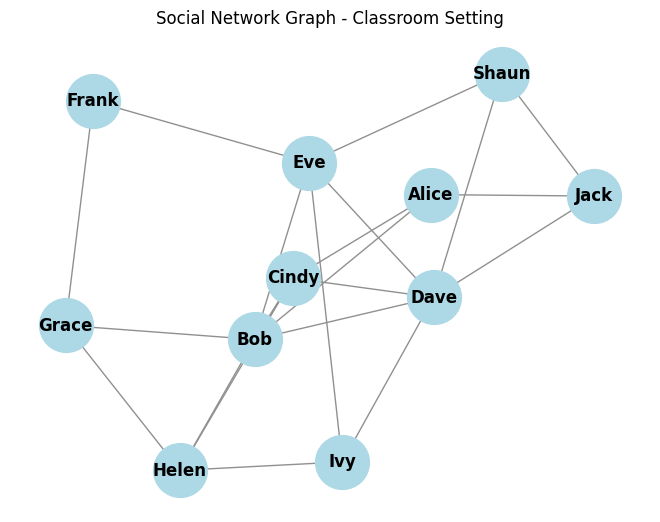

In [5]:
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes using the spring layout
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold', node_size=1500, edge_color='#909090')
plt.title("Social Network Graph - Classroom Setting")
plt.show()

In [6]:
# Compute basic properties
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Compute the longest shortest path between any pair of nodes
print("Longest shortest path:", nx.diameter(G))

# Compute the minimum eccentricity
print("Radius of the graph:", nx.radius(G))

# Compute the degree to which nodes in a graph tend to cluster together
print("Average clustering coefficient:", nx.average_clustering(G))

Number of nodes: 11
Number of edges: 21
Longest shortest path: 3
Radius of the graph: 2
Average clustering coefficient: 0.34545454545454546


In [7]:
from neo4j import GraphDatabase

# Load data from neo4j into networkx object

def create_networkx_graph_from_neo4j(uri, user, password):
    # Initialize the Neo4j driver
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Define the Cypher query
    query = "MATCH (n)-[r]-(c) RETURN n, r, c"

    # Initialize an empty Graph (undirected)
    G = nx.Graph()

    with driver.session() as session:
        results = session.run(query)

        for record in results:
            start_node = record['n']
            end_node = record['c']
            relationship = record['r']

            # Add nodes with properties
            G.add_node(start_node.id, **dict(start_node))
            G.add_node(end_node.id, **dict(end_node))

            # Add edge with properties, avoiding duplicates
            if not G.has_edge(start_node.id, end_node.id):
                G.add_edge(start_node.id, end_node.id, **dict(relationship))

    driver.close()
    return G

uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'
G = create_networkx_graph_from_neo4j(uri, user, password)


ModuleNotFoundError: No module named 'neo4j'

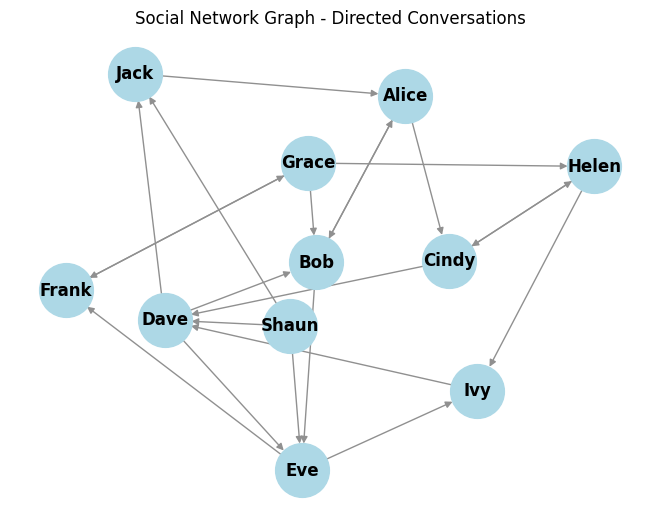

In [8]:
# Create a new directed graph
DG = nx.DiGraph()

# Add nodes
nodes = [
  "Alice", "Bob", "Cindy", "Dave", "Eve", "Frank", 
  "Grace", "Helen", "Ivy", "Jack", "Shaun"
]

DG.add_nodes_from(nodes)

# Add directed edges (assuming some are bi-directional)
directed_edges = [
    ("Alice", "Bob"), ("Bob", "Alice"),  # Alice and Bob talked to each other
    ("Alice", "Cindy"), 
    ("Cindy", "Dave"), 
    ("Dave", "Eve"), 
    ("Eve", "Frank"), 
    ("Frank", "Grace"), ("Grace", "Frank"), 
    ("Grace", "Helen"), 
    ("Helen", "Ivy"), 
    ("Jack", "Alice"),  # Jack initiated a conversation with Alice
    ("Bob", "Eve"), 
    ("Dave", "Bob"), 
    ("Cindy", "Helen"), 
    ("Dave", "Jack"), 
    ("Eve", "Ivy"), 
    ("Grace", "Bob"), 
    ("Helen", "Cindy"), ("Cindy", "Helen"),
    ("Ivy", "Dave"), 
    ("Shaun", "Dave"), 
    ("Shaun", "Eve"), 
    ("Shaun", "Jack")
]

DG.add_edges_from(directed_edges)

# Draw the directed graph
nx.draw(DG,with_labels=True, node_color='lightblue', font_weight='bold', node_size=1500, edge_color='#909090', arrows=True)
plt.title("Social Network Graph - Directed Conversations")
plt.show()

In [15]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_embeddings):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 32) # First GCN layer
        self.conv2 = GCNConv(32, 16) # Second GCN layer
        self.conv3 = GCNConv(16, num_embeddings) # Third GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model = GCN(num_features=32, num_embeddings=16)

In [18]:
from torch_geometric.nn import MessagePassing

class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNConv, self).__init__(aggr='add')  # Use 'add' for summation aggregation.

        # Trainable weight matrices
        self.W = torch.nn.Parameter(torch.Tensor(out_channels, in_channels))
        self.B = torch.nn.Parameter(torch.Tensor(out_channels, in_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.W, nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.B, nonlinearity='relu')  # Initialize using a suitable method

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Compute the degree of each node
        row, _ = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype) + 1  # Degree with self-loops

        # Compute the new features
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, deg=deg)

    def message(self, x_j, norm):
        # Normalize features
        return torch.matmul(x_j, self.W)

    def update(self, aggr_out, x, deg):
        # Apply weights, add transformed self features, apply bias (also transformed), and divide by degree
        aggr_out = torch.matmul(aggr_out, self.W.t()) + torch.matmul(x, self.B.t())
        aggr_out = aggr_out / (deg.view(-1, 1))
        return F.relu(aggr_out)